In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib import cm
%matplotlib  widget

In [ ]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# load in dates, make sure they are in order
dates = [os.path.basename(d) for d in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); ni = nd-1
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(nd):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
igram_dates = slc_dates[0:-1] 

# Dimensions of this area 
dx = 4000
dy = 1100

# reference point 
# refX = 3519
# refY = 938
refX = 3694
refY = 443

# make a conversion factor from radians to cm. 
wavelength = 5.5465763          # C-band, in cm 
rad2cm = wavelength/(4*np.pi)   # this is conversion factor

In [3]:
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'

In [4]:
# load in reference point values 
ref_phs = np.ndarray((ni,),dtype='float')
for i in range(ni):
        igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        ref_phs[i] = ds.GetRasterBand(1).ReadAsArray(refX,refY,1,1)[0,0]
        #print(i, ref_phs[i])

Define a function to extract a time series and pull out coherence over time at a specific point, and converts to cm.

In [5]:
# j is interval, y is y-coord of pixel, x is x-coord of pixel
def time_series(y,x):
   
    # set up temp arrays for the pixel I'm extracting
    phs = np.ndarray((ni,),dtype='float')
    coh = np.ndarray((ni,),dtype='float')

    # load in phase values for single pixel, subtract ref value, load coherences for that pixel
    for i in range(ni):
        date1 = dates[i]
        date2 = dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        # only reading in one row at a time 
        phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)[0,0]     # (startx,starty,dx,dy)  
        # correct based on reference phase value 
        phs[i] = phs[i] - ref_phs[i]
        # load one line of coherence files
        cohFile = 'coh_'+date1+'-'+date2+'.r4'
        ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
        # only reading in one row at a time
        coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)[0,0]
        
    cum_phs = np.cumsum(phs)
    cum_disps = cum_phs*rad2cm

    return cum_disps, coh

Load velocity map. (From Mintpy)

In [6]:
# load in mintpy results 
mintpy_file = '/home/ocp4/data/LagunaSalada/Data_and_Figs/12_rate_inversions/full_mintpy/velocity.h5'
band='velocity'
ds = gdal.Open("HDF5:\"{}\"://{}".format(mintpy_file,band))
mintpy_rates = ds.GetRasterBand(1).ReadAsArray()
# convert from m/yr to cm/yr and swap the sign convention. + is subsidence now.
disp_rates = -mintpy_rates*100

In [7]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


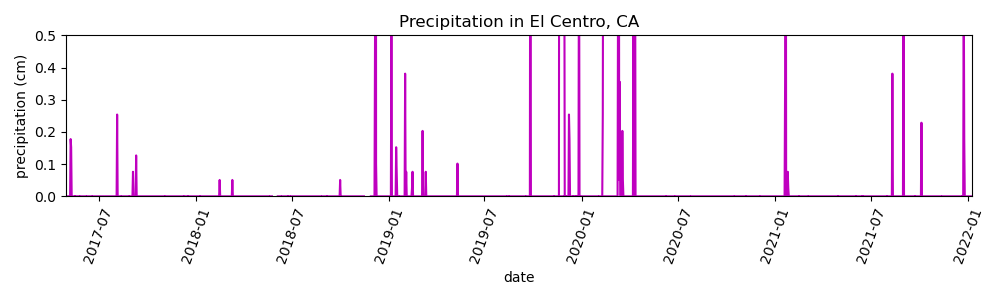

i 	date 		       precip > 0.0cm
584	2018-12-06 00:00:00    0.48260000000000003 cm
585	2018-12-07 00:00:00    4.572 cm
615	2019-01-06 00:00:00    0.5334 cm
641	2019-02-01 00:00:00    0.381 cm
878	2019-09-26 00:00:00    1.4478 cm
933	2019-11-20 00:00:00    2.286 cm
934	2019-11-21 00:00:00    1.016 cm
942	2019-11-29 00:00:00    1.016 cm
970	2019-12-27 00:00:00    0.9398 cm
1016	2020-02-11 00:00:00    1.1684 cm
1044	2020-03-10 00:00:00    0.7365999999999999 cm
1045	2020-03-11 00:00:00    2.4892 cm
1047	2020-03-13 00:00:00    0.3556 cm
1073	2020-04-08 00:00:00    0.6096 cm
1076	2020-04-11 00:00:00    0.9906 cm
1360	2021-01-20 00:00:00    0.3556 cm
1361	2021-01-21 00:00:00    1.7779999999999998 cm
1563	2021-08-11 00:00:00    0.381 cm
1584	2021-09-01 00:00:00    0.7112 cm
1698	2021-12-24 00:00:00    0.7112 cm


In [8]:
# Read in raw precipitation data and plot it 
file = '/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip.txt'
precip_all = np.loadtxt(file, delimiter=',', skiprows=3, dtype=str)
precipDates = precip_all[:,0]
precip_all = precip_all[:,1]
precip_all = precip_all.astype(float)
# convert to cm from inches 
precip_all = precip_all*2.54
# make the dates from precip.txt into datetime objects
my_dates=[]
for i in range(0,len(precipDates)):
    my_dates.append(datetime.strptime(str(precipDates[i]).replace('\n',''), '%Y-%m-%d'))

fig=plt.figure(figsize=(10,3), tight_layout=True)
#plt.xticks(np.arange(0, np.size(precipDates)+1, 182))
plt.xticks(rotation = 70)
#plt.plot(precipDates, precip,'-m')
plt.plot(my_dates, precip_all,'-m')
plt.xlabel('date')
plt.ylabel('precipitation (cm)')
plt.xlim([np.min(my_dates), np.max(my_dates)])
#plt.xlim([0, np.size(precip)])
plt.ylim([0,0.5])
plt.title('Precipitation in El Centro, CA')
plt.show()

print('i \tdate \t\t       precip > 0.0cm')
rainy_dates = []
rainy_amts = []
for i in np.arange(len(precip_all)): 
    if precip_all[i] > 0.3:
        print(str(i)+'\t'+str(my_dates[i])+'    '+str(precip_all[i])+' cm')
        rainy_dates.append(my_dates[i])
        rainy_amts.append(precip_all[i])
rainy_amts2 = np.ndarray((np.shape(rainy_amts)),dtype='float')
for i in range(len(rainy_amts)):
    rainy_amts2[i] = float(rainy_amts[i])
# normalize to the largest rain event so all values are btw 0-1
rainy_amts2 = rainy_amts2/np.max(rainy_amts)
rainy_amts2 = 0.8*rainy_amts2+0.2

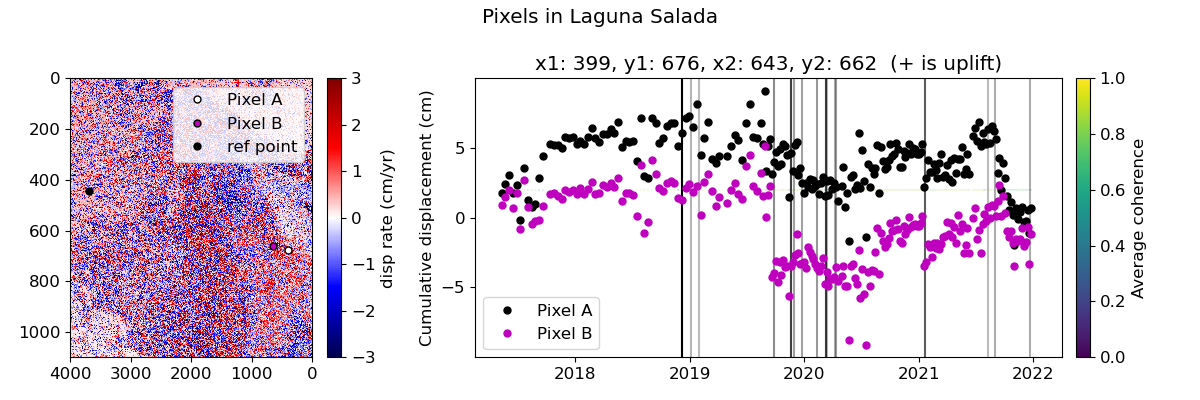

In [9]:
# TRY PIXELS IN LAGUNA SALADA ITSELF TO MAKE SURE ITS UPLIFTING???

x1 = 399
y1 = 676
x2 = 643
y2 = 662

def plot_ts_ls(x1,y1,x2,y2):
    cum_disps_pt1, coh_at_pixel_pt1 = time_series(y1,x1)
    cum_disps_pt2, coh_at_pixel_pt2 = time_series(y2,x2)

    # time series colored by coherence for both points
    coh = (coh_at_pixel_pt1+coh_at_pixel_pt2)/2
    coh_cmap = cm.get_cmap('viridis', 100)

    # Make default font size bigger
    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(12,4),tight_layout=True)
    plt.subplot(1,3,1)
    plt.imshow(disp_rates,cmap='seismic',aspect='auto',vmin=-3,vmax=3,interpolation='none')
    plt.plot(x1,y1,'w.',ms=10,mec='k',label='Pixel A')
    plt.plot(x2,y2,'m.',ms=10,mec='k',label='Pixel B')
    plt.plot(refX,refY,'k.',ms=10,label='ref point')
    plt.legend()
    plt.colorbar(label='disp rate (cm/yr)')
    plt.xlim(dx,0)

    plt.subplot(1,3,(2,3))
    plt.scatter(igram_dates,np.ones((nd-1))*2,c=coh_at_pixel_pt1,cmap='viridis',vmin=0,vmax=1,s=0.01)
    plt.plot(igram_dates,-cum_disps_pt1,'k.',markersize=10,label='Pixel A')
    plt.plot(igram_dates,-cum_disps_pt2,'m.',markersize=10,label='Pixel B')
    plt.legend()
    plt.ylabel('Cumulative displacement (cm)')
    Ymin,Ymax = plt.gca().get_ylim()

    y = Ymax+0.1*(Ymax-Ymin)
    for i in range(ni):
        plt.hlines(y,slc_dates[i],slc_dates[i+1],color=coh_cmap(coh[i]),linewidth=20)
    plt.colorbar(label='Average coherence',pad=0.02)
    plt.ylim(Ymin,Ymax+0.2*(Ymax-Ymin))

    # ALL rainy days (not just day of/prior to an SLC date)
    plt.vlines(rainy_dates,Ymin,Ymax,'k',zorder=1,alpha=rainy_amts2)
    plt.ylim([Ymin,Ymax])
    plt.locator_params(axis="y", integer=True,tight=True)

    plt.title('x1: '+str(x1)+', y1: '+str(y1)+', x2: '+str(x2)+', y2: '+str(y2)+'  (+ is uplift)')
    #plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/time_series_setI_for_paper.png',transparent=True)

    plt.suptitle('Pixels in Laguna Salada')
    plt.show()

plot_ts_ls(x1,y1,x2,y2)